In [42]:
import itertools
import sys
from IPython.html.widgets.widget_float import FloatProgress
import matplotlib as mpl
import pymol
from pymol import cmd, stored
import matplotlib
from matplotlib import cm

In [43]:
pymol.pymol_argv = ['pymol', '-qc'] # quiet / no GUI
stdout = sys.stdout
stderr = sys.stderr
pymol.finish_launching(['pymol', '-xiq'])
sys.stdout = stdout
sys.stderr = stderr

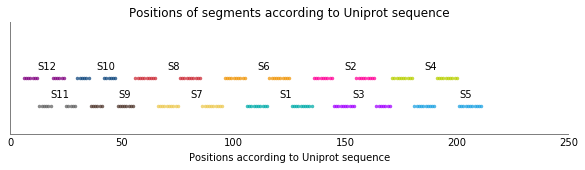

1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


Now the following variables are available:

- data: all data as a (sorted) dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe'

- unique_single_mutations: a dictionary with all single mutations for every segment

- data_singles: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe' for genotypes containing a single substitution

- single_mut_fitness_dict: a dictionary in the form: 'single mutation' : 'fitness'

- data_known_mutations_only - a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe', 
but only for those genotypes that consist of mutations with known effects (single mutant is measured).
For this dictionary, epistasis is measured for every genotype.

# # # # # # # # # # # # # # # # #




In [44]:
%run 'ks08_Epistasis_in_all_backgrounds.ipynb'
notebook_prefix = 'ks09'
image_counter = Counter()
session_counter = Counter()

#### Summary of epistatic interactions

In [45]:
epdict__segment_pos1_pos2 = get_empty_segment_position1_position2_defaultdict(ep_dict)
epdict__segment_pos1_pos2 = fill_dictionary_with_values(epdict__segment_pos1_pos2, ep_dict)
filtered_dict = filter_segment_position1_position2_dict(epdict__segment_pos1_pos2, 'fraction_strong')

NameError: global name 'epistasis_by_positions' is not defined

### PyMol visualizations

In [ ]:
pdb_file = 'files_dump/structure_visualizations/HIS3_saccharomyces_cerevisiae__itasser_model1_prediction__aligned_with_4LOM.pse'

for segment in data:
    for position in ep_std_by_position[segment]:
        
        other_positions, values = filtered_dict[segment][position]
        max_value = 0.3 # to color everything in the same scale
        values = values[:]
        values.extend([0, max_value])
        values = [min([max_value, v]) for v in values]

        title = 'Epistasis between position %s in segment %s and other positions' %(position, segment)
        folder_to_save = check_dir(os.path.join(pymol_sessions_folder, 
                                                'epistasis_between_pairs_of_positions'+'__'+what_to_look_at, segment.split('_')[0]))
        cmd.reinitialize()
        open_or_fetch(pdb_file)
        color_positions(other_positions, values=values, representation='spheres', colormap=mpl.cm.Blues)
        cmd.color('red', 'resi %s' %position)
        cmd.show('spheres', 'resi %s' %position)
        cmd.hide('everything', '4LOM')
        cmd.color('orange', 'ligand')
        cmd.show('spheres', 'ligand')
        save_session_properly(session_counter, title, folder_to_save, notebook_prefix)

### Heatmap of epistasis

In [ ]:
pdb_file = "files_dump/structure_predictions/HIS3_saccharomyces_cerevisiae__itasser_model1_prediction.pdb" 
structure = Bio.PDB.PDBParser().get_structure('His3_itasser', pdb_file)
model = structure[0]

In [ ]:
residues = list(model.get_residues())

In [ ]:
def calc_residue_dist(residue_one, residue_two):
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

In [ ]:
to_correlate = {}
ep_matrix = np.zeros((230, 230), np.float)
dist_matrix = np.zeros((230, 230), np.float)
plot_better()
for segment in epistasis_by_positions:
    for position1 in epistasis_by_positions[segment]:
        for position2 in epistasis_by_positions[segment][position1]:
            distance_value = calc_residue_dist(residues[int(position1)-1], residues[int(position2)-1])
            epistasis_value = np.max(epistasis_by_positions[segment][position1][position2]['fraction_strong'])
            dist_matrix[position1, position2] = distance_value
            ep_matrix[position1, position2] = epistasis_value
            to_correlate[tuple(sorted((position1, position2)))] = distance_value, epistasis_value
            plt.scatter(distance_value, epistasis_value, edgecolor='none', color=segment_colors[segment.split('_')[0]], alpha=0.5)
            title = 'Epistasis between pairs of positions'
            y_label = 'Epistasis between pairs of positions\n(fraction of genotypes under epistasis >%s in all backgrounds)' %ep_threshold
            plt.ylabel(y_label)
            plt.xlabel('Distance between positions')
            plt.title(title)

In [ ]:
plot_better(width=16, height=8)

ax = plt.subplot(121)
im = plt.imshow(ep_matrix, cmap=matplotlib.cm.BuPu, origin='lower', vmax=0.3)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Fraction of strong epistatic interactions', rotation=270)

plt.xlim(0,230)
plt.ylim(-30,230)
plt.xlabel('Position')
plt.ylabel('Position')
title = 'Epistasis between pairs of positions'
title += '\n(fraction of genotypes under epistasis >%s in all backgrounds)' %ep_threshold
plt.title(title)
improve_plot(ax)


ax = plt.subplot(122)
im = plt.imshow(dist_matrix, cmap=matplotlib.cm.BuPu, origin='lower', vmax=25)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Distance, A', rotation=270)

#plotting the segments
old_y = -20
for row in positions.iterrows():
    for position in row[1].positions_Uniprot_P06633:
        new_y = np.random.choice([-10,-20])
        while new_y == old_y:
            new_y = np.random.choice([-10,-20])
    x = row[1].positions_Uniprot_P06633
    plt.plot(x, [new_y for e in x], '.', lw=3, alpha=0.7, label=row[1].segment, color=segment_colors[row[1].segment])
    plt.text(np.median(x), new_y + 2, row[1].segment)
    old_y = new_y
plt.xlim(0,230)
plt.ylim(-30,230)
plt.xlabel('Position')
plt.ylabel('Position')
plt.title('Distance between pairs of positions')
improve_plot(ax)


plt.tight_layout()

In [ ]:
directory = os.path.join(files_dump_folder, 'impacts_of_mutations_in_all_backgrounds__full_lib', '')
fitness_impacts = OrderedDict()
list_of_files = [f for f in os.listdir(directory) if '.hdf' in f]
for f in list_of_files:
    mut = f.rstrip('.hdf').split('_')[-1]
    fitness_impacts[mut] = pd.read_hdf(directory + f, 'data')

In [ ]:
dot_color = '#E91348'
plot_better(width=14, height=9)
title ='Fraction of strong epistasis vs distance between positions  in all backgrounds'
for index, segment in enumerate(data.keys()):
    to_correlate = []
    ax = plt.subplot(3,4,index+1)
    for position1 in epistasis_by_positions[segment]:
        for position2 in epistasis_by_positions[segment][position1]:
            distance_value = calc_residue_dist(residues[int(position1)-1], residues[int(position2)-1])
            for value in epistasis_by_positions[segment][position1][position2]['fraction_strong']:
                to_correlate.append((distance_value, value))
                plt.scatter(distance_value, value, color='blue', edgecolor='none', alpha=0.1)
    subtitle = 'Epistasis vs distance in %s' % segment.split('_')[0]
    subtitle += '\n spearman coeff = %.2f' %stats.spearmanr(to_correlate)[0]
    plt.title(subtitle)
    plt.xlim(0,43)
    plt.ylim(0,0.7)
    plt.xlabel('Distance between positions, A')
    plt.ylabel('Fraction of strong epistasis\nbetween pairs of mutations')
    improve_plot(ax)
plt.tight_layout()
save_image(image_counter, title, figures_folder, notebook_prefix)

In [ ]:
dot_color = '#E91348'
plot_better(width=14, height=9)
title ='Fraction of strong epistasis vs fitness of interacting mutations  in all backgrounds'
for index, segment in enumerate(data.keys()):
    to_correlate = []
    ax = plt.subplot(3,4,index+1)
    improve_plot(ax)
    for mutA, mutB in ep_dict[segment]:
        ep = ep_dict[segment][mutA, mutB]
        ep_fraction = 1. * len(ep[np.abs(ep) > ep_threshold]) / len(ep)
        fitness_value = fitness_impacts[mutA].mean() + fitness_impacts[mutB].mean()
#         fitness_value = np.abs(fitness_impacts[mutA].mean()) + np.abs(fitness_impacts[mutB].mean())
        plt.scatter(fitness_value, ep_fraction, color=dot_color, edgecolor='none', alpha=0.1)    
        to_correlate.append((fitness_value, ep_fraction))
    subtitle = 'Epistasis vs fitness in %s' % segment.split('_')[0]
    subtitle += '\n spearman coeff = %.2f' %stats.spearmanr(to_correlate)[0]
    plt.title(subtitle)
    plt.ylim(0,0.7)
    plt.xlim(-0.7, 0.1)
    plt.axvline(0, color='gray')
    plt.xlabel('Sum of av. fitness impacts\nof interacting mutations')
    plt.ylabel('Fraction of strong epistasis\nbetween pairs of mutations')

plt.tight_layout()
save_image(image_counter, title, figures_folder, notebook_prefix)

### Sign epistasis from Lucas

In [ ]:
position_translation = pd.read_table('/Users/karen/Downloads/position_translation.csv')
position_translation.set_index('relative_position', inplace=True)

In [47]:
def get_absolute_position(segment_number, relative_position):
    return int(position_translation.iloc[relative_position]['S'+str(segment_number)])

lucas_sign_epistasis = pd.read_excel('/Users/karen/Downloads/SignEpiPairs.xlsx')
lucas_sign_epistasis['VarPos_absolute'] = lucas_sign_epistasis.apply(lambda df: get_absolute_position(df['SegN'], df['VarPos']-1), axis=1)
lucas_sign_epistasis['SubPos_absolute'] = lucas_sign_epistasis.apply(lambda df: get_absolute_position(df['SegN'], df['SubPos']-1), axis=1)
lucas_sign_epistasis['distance'] = lucas_sign_epistasis.apply(lambda df: calc_residue_dist(residues[df['VarPos_absolute']-1], residues[df['SubPos_absolute']-1]), axis=1)

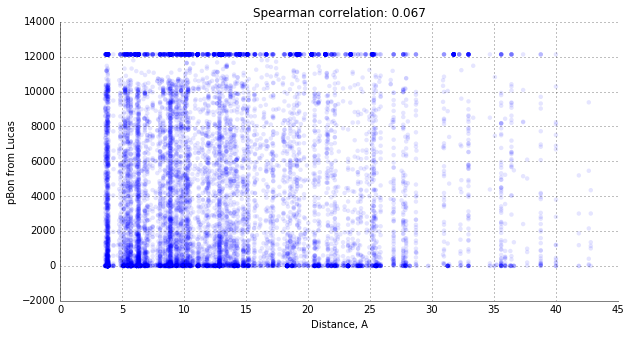

In [48]:
plot_better()
plt.scatter(lucas_sign_epistasis['distance'], lucas_sign_epistasis['pBon'], edgecolor='none', alpha=0.1)
correlation = stats.spearmanr(lucas_sign_epistasis['distance'], lucas_sign_epistasis['pBon'])
plt.xlabel('Distance, A')
plt.ylabel('pBon from Lucas')
plt.title('Spearman correlation: %.3f' %correlation[0])